In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json

from celltype_mapping import TangramMapping
from sawg import SpotTable, ExpressionDataset

In [90]:
with open('//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/snRNAseq_data/ordered_celltype_labels.json') as file:
            ordered_labels = json.load(file)

In [2]:
barcode =  '1191380959'
region = 'mtg'

In [3]:
data_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis'

sp_data_path = data_path + '/NHP_spatial/MERSCOPE/macaque/' + barcode

sc_anndata_file = data_path + '/NHP_spatial/snRNAseq_data/macaque_MTG_logcpm.h5ad'

# path for storing tangram mapping
tg_mapping_path = [dirpath for dirpath, _, _ in os.walk(sp_data_path) if dirpath.endswith('mapping')]

if len(tg_mapping_path) > 1:
    region_path = [path for path in tg_mapping_path if region in path]
    if len(region_path)==1:
        tg_mapping_path = region_path[0]
    else:
        print("Can't find singular path")
print(tg_mapping_path)

//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1191380959\region_0\mtg\mapping


In [4]:
# get mappings for barcode
for mapping_ts in os.listdir(tg_mapping_path):
    print(mapping_ts)
    meta = TangramMapping.load_from_timestamp(tg_mapping_path, mapping_ts, meta_only=True)
    pprint.pprint(meta)

1666822812.002
{'cluster_label': 'subclass',
 'merscope_barcode': 1191380959,
 'mode': 'clusters',
 'segmentation': 'cellpose_cyto2_nuclei',
 'segmentation_filters': {'n_genes': [20, 420],
                          'n_spots': [100, 3500],
                          'volume': [100, 3500]},
 'snRNAseq': 'raw UMI',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'MERSCOPE',
 'spatial_region': 'MTG',
 'training_genes': 'VZG600 panel'}
1666890074.598
{'cluster_label': 'cluster',
 'merscope_barcode': 1191380959,
 'mode': 'clusters',
 'segmentation': 'cellpose_cyto2_nuclei',
 'segmentation_filters': {'n_genes': [20, 420],
                          'n_spots': [100, 3500],
                          'volume': [100, 3500]},
 'snRNAseq': 'raw UMI',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'MERSCOPE',
 'spatial_region': 'MTG',
 'training_genes': 'VZG600 panel'}
1667254420.423
{'cluster_label': 'subclass',
 'merscope_barcode': 1191380959,
 'mode': 'clusters',
 'segmentation': 'cellpose_cyto2_nucle

In [5]:
tg_map = TangramMapping.load_from_timestamp(tg_mapping_path, '1667514967.374') #1667514967.374
pprint.pprint(tg_map.meta)

{'cluster_label': 'cluster',
 'merscope_barcode': 1191380959,
 'mode': 'clusters',
 'segmentation': 'cellpose_cyto2_nuclei',
 'segmentation_filters': {'n_genes': (20, 420),
                          'n_spots': (100, 3500),
                          'volume': (100, 3500)},
 'snRNAseq': 'raw UMI',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'MERSCOPE',
 'spatial_region': 'MTG',
 'training_genes': 'mFISHtools panel'}


In [6]:
tg_map.get_discrete_cell_mapping(threshold=0.1)

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [161]:
discrete_mapping = tg_map.ad_sp.obsm['discrete_ct_pred'][['cluster', 'cluster_prop', 'x', 'y']]
discrete_mapping.head()

,cluster,cluster_prop,x,y
cell,,,,
1019095826100270249,Micro-PVM_3,1.000000,3895.770335,625.912326
1019095826100300124,Micro-PVM_3,0.202411,5750.175333,436.002554
1019095826100310136,Oligo_2,0.133543,6295.305789,813.067863
1019095826100310139,Oligo_1,0.144517,6278.814060,820.291813
1019095826100310140,Astro_1,0.289354,6263.352582,823.191133


Text(0.5, 1.0, 'L6 IT Car3_2')

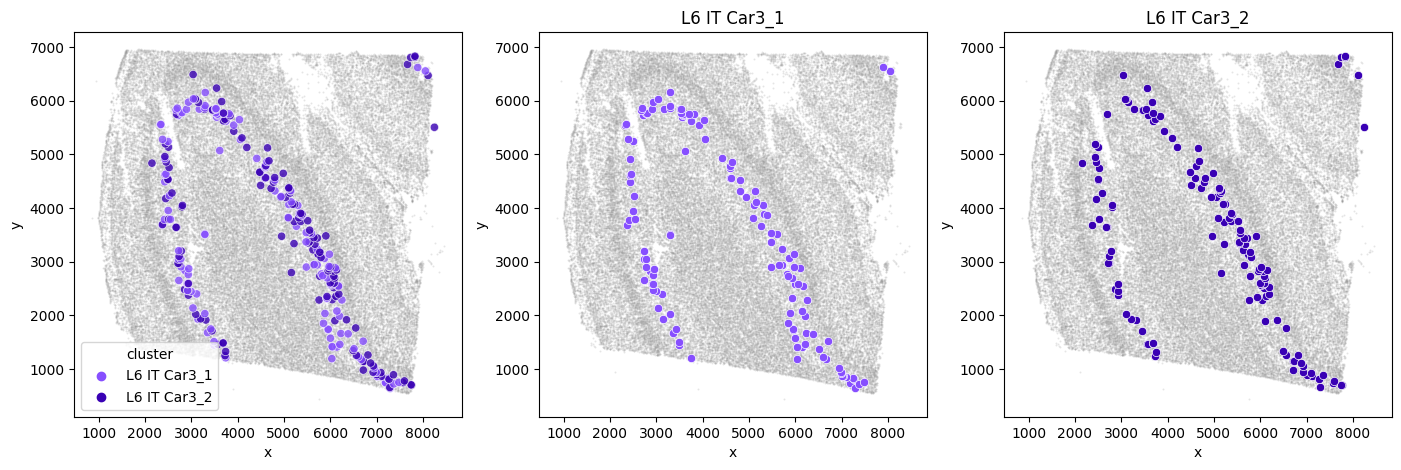

In [162]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

data = discrete_mapping[discrete_mapping['cluster'].isin(['L6 IT Car3_1', 'L6 IT Car3_2'])]

for axs in ax:
    sns.scatterplot(data=tg_map.ad_sp.obsm['discrete_ct_pred'], x='x', y='y', color='grey', alpha=0.2, s=2, ax=axs)
sns.scatterplot(data=data, x='x', y='y', hue='cluster', ax=ax[0], alpha=0.8, palette=ordered_labels['cluster'])
sns.scatterplot(data=data[data['cluster']=='L6 IT Car3_1'], x='x', y='y', ax=ax[1], color=ordered_labels['cluster']['L6 IT Car3_1'])
ax[1].set_title('L6 IT Car3_1')
sns.scatterplot(data=data[data['cluster']=='L6 IT Car3_2'], x='x', y='y', ax=ax[2], color=ordered_labels['cluster']['L6 IT Car3_2'])
ax[2].set_title('L6 IT Car3_2')

In [163]:
discrete_mapping['subclass'] = None
discrete_mapping['class'] = None

for cls in ['exc', 'inh', 'glia']:
    for subclass, clusters in ordered_labels[cls].items():
        discrete_mapping.loc[discrete_mapping['cluster'].isin(clusters), 'subclass'] = subclass
        discrete_mapping.loc[discrete_mapping['cluster'].isin(clusters), 'class'] = cls

In [164]:
class_perc = discrete_mapping.groupby(['cluster', 'class']).count()
class_perc['Perc of class'] = class_perc.apply(lambda x: x['cluster_prop'] / class_perc.groupby('class').sum().loc[x.name[1]][0] * 100,
                                               axis=1)
class_perc.rename(columns={'cluster_prop': 'n_cells'}, inplace=True)
class_perc.drop(columns=['x', 'y', 'subclass'], inplace=True)
class_perc.reset_index(inplace=True, level=['class'])
class_perc.head()

,class,n_cells,Perc of class
cluster,,,
Astro_1,glia,335,1.706398
Astro_2,glia,2937,14.960269
Astro_3,glia,973,4.956194
Chandelier_1,inh,110,1.646953
Chandelier_2,inh,168,2.515347


In [165]:
discrete_mapping = discrete_mapping.merge(tg_map.ad_sp.to_df()['cux2'], left_index=True, right_index=True)
discrete_mapping.head()

,cluster,cluster_prop,x,y,subclass,class,cux2
cell,,,,,,,
1019095826100270249,Micro-PVM_3,1.000000,3895.770335,625.912326,Micro-PVM,glia,0.0
1019095826100300124,Micro-PVM_3,0.202411,5750.175333,436.002554,Micro-PVM,glia,0.0
1019095826100310136,Oligo_2,0.133543,6295.305789,813.067863,Oligo,glia,0.0
1019095826100310139,Oligo_1,0.144517,6278.814060,820.291813,Oligo,glia,0.0
1019095826100310140,Astro_1,0.289354,6263.352582,823.191133,Astro,glia,0.0


Text(0, 0.5, 'CUX2 expression')

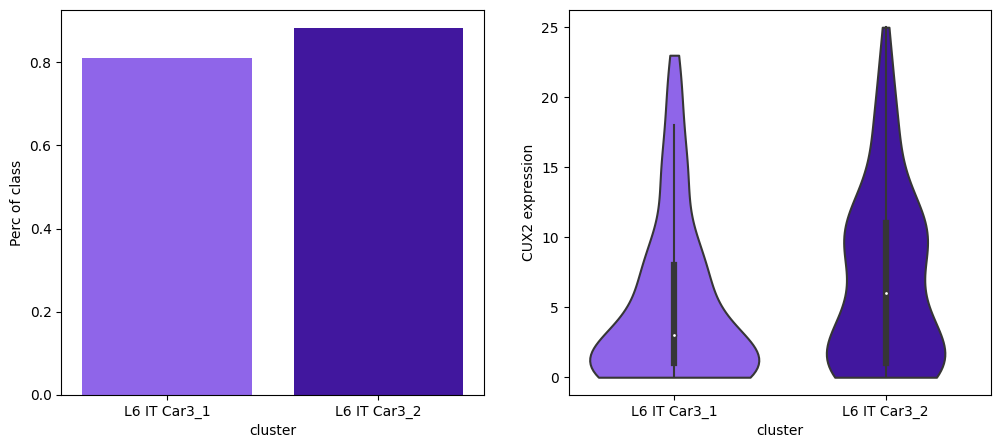

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
l6ITCar3 = ['L6 IT Car3_1', 'L6 IT Car3_2']
sns.barplot(data=class_perc.loc[l6ITCar3], x=class_perc.loc[l6ITCar3].index, 
            y='Perc of class', ax=ax[0], palette=ordered_labels['cluster'], order=l6ITCar3)
sns.violinplot(data=discrete_mapping[discrete_mapping['cluster'].isin(l6ITCar3)], x='cluster', y='cux2', cut=0,
               palette=ordered_labels['cluster'], ax=ax[1], order=l6ITCar3)
ax[1].set_ylabel('CUX2 expression')

<AxesSubplot: xlabel='x', ylabel='y'>

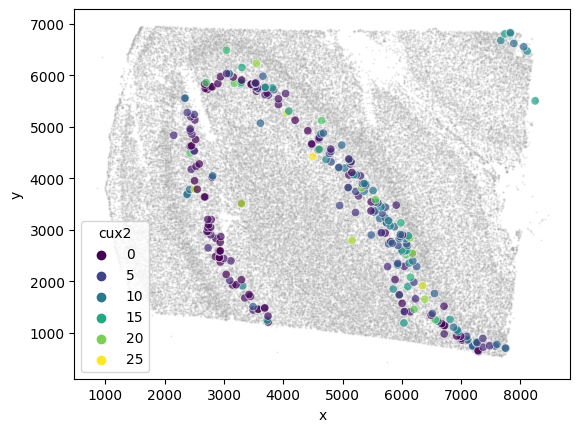

In [169]:
fig, ax = plt.subplots()

sns.scatterplot(data=tg_map.ad_sp.obsm['discrete_ct_pred'], x='x', y='y', color='grey', alpha=0.2, s=2, ax=ax)
sns.scatterplot(data=discrete_mapping[discrete_mapping['cluster'].isin(l6ITCar3)], x='x', y='y', hue='cux2', palette='viridis', 
                alpha=0.7, ax=ax)

<AxesSubplot: xlabel='cux2', ylabel='Count'>

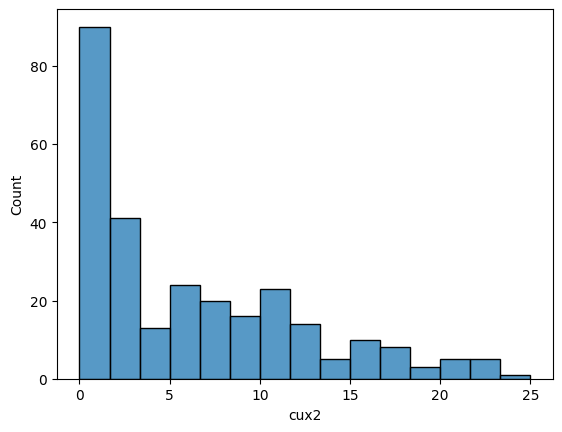

In [173]:
sns.histplot(data=discrete_mapping[discrete_mapping['cluster'].isin(l6ITCar3)], x='cux2', bins=15)

In [175]:
tg_map.ad_sc

AnnData object with n_obs × n_vars = 49747 × 31200
    obs: 'cluster', 'subclass', 'class'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'

In [17]:
tg_stereoseq = TangramMapping.load_from_timestamp(data_path + '/NHP_spatial//BGI/cDNAD5/mapping', '1677105109.006') 
pprint.pprint(tg_stereoseq.meta)

{'cluster_label': 'cluster',
 'mode': 'clusters',
 'training_genes': 'cluster RNAseq markers above median ROC'}


In [20]:
tg_stereoseq.get_discrete_cell_mapping(threshold=0.1)

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [61]:
tg_stereoseq_bin50 = TangramMapping.load_from_timestamp(data_path + '/NHP_spatial//BGI/cDNAD5/mapping', '1677602751.488') 
pprint.pprint(tg_stereoseq.meta)

{'cluster_label': 'cluster',
 'mode': 'clusters',
 'training_genes': 'cluster RNAseq markers above median ROC'}


In [63]:
tg_stereoseq_bin50.get_discrete_cell_mapping(threshold=0.1)

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


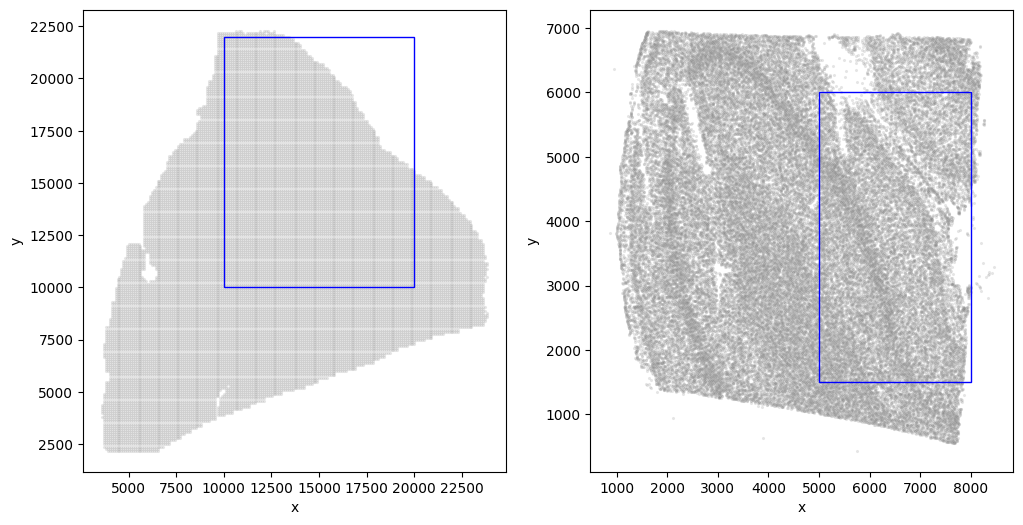

In [74]:
def plot_rect(xlim, ylim, ax, color):
    import matplotlib.patches
    pos = (xlim[0], ylim[0])
    width = xlim[1] - xlim[0]
    height = ylim[1] - ylim[0]
    rect = matplotlib.patches.Rectangle(pos, width, height, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    return rect

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=tg_stereoseq.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[0])
# plot_rect((10000, 17500), (15000, 22000), ax[0], 'r')
plot_rect((10000, 20000), (10000, 22000), ax[0], 'b')
sns.scatterplot(data=tg_map.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[1])
# plot_rect((5000, 8000), (2000, 5000), ax[1], 'r')
plot_rect((5000, 8000), (1500, 6000), ax[1], 'b')

(2000.0, 5000.0)

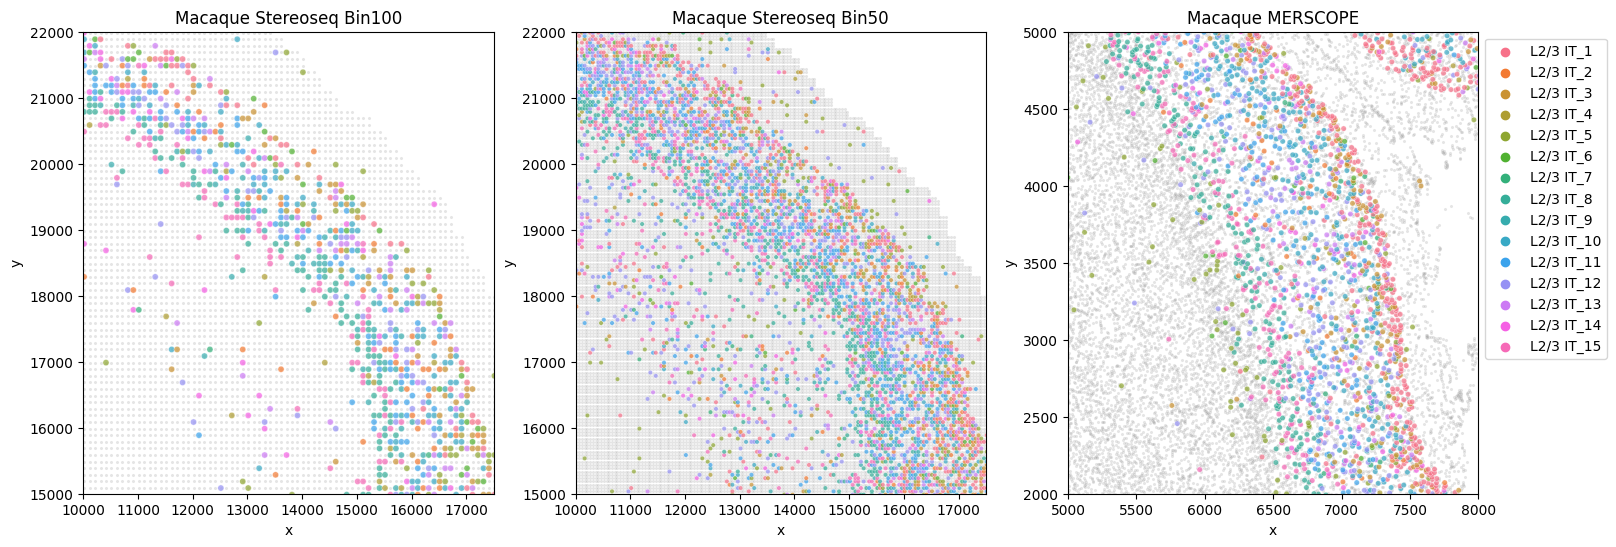

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=tg_stereoseq.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[0])
sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['subclass']=='L2/3 IT'], 
                x='x', y='y', hue='cluster', alpha=0.7, s=20, legend=False,
                hue_order=[l for l in tg_stereoseq.ordered_labels['cluster'] if l.startswith('L2/3 IT')], ax=ax[0])
# sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['cluster']=='L2/3 IT_15'],
#                x='x', y='y', color='k', size=30, ax=ax[0])
ax[0].set_title('Macaque Stereoseq Bin100')
ax[0].set_xlim(10000, 17500)
ax[0].set_ylim(15000, 22000)

sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[1])
sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred']['subclass']=='L2/3 IT'], 
                x='x', y='y', hue='cluster', alpha=0.7, s=10, legend=False,
                hue_order=[l for l in tg_stereoseq_bin50.ordered_labels['cluster'] if l.startswith('L2/3 IT')], ax=ax[1])
ax[1].set_title('Macaque Stereoseq Bin50')
ax[1].set_xlim(10000, 17500)
ax[1].set_ylim(15000, 22000)

sns.scatterplot(data=tg_map.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[2])
sns.scatterplot(data=tg_map.ad_sp.obsm['discrete_ct_pred'][tg_map.ad_sp.obsm['discrete_ct_pred']['subclass']=='L2/3 IT'], 
                x='x', y='y', hue='cluster', alpha=0.7, s=15, 
                hue_order=[l for l in tg_map.ordered_labels['cluster'] if l.startswith('L2/3 IT')], ax=ax[2])
ax[2].set_title('Macaque MERSCOPE')
ax[2].legend(bbox_to_anchor=(1,1))
ax[2].set_xlim(5000, 8000)
ax[2].set_ylim(2000, 5000)


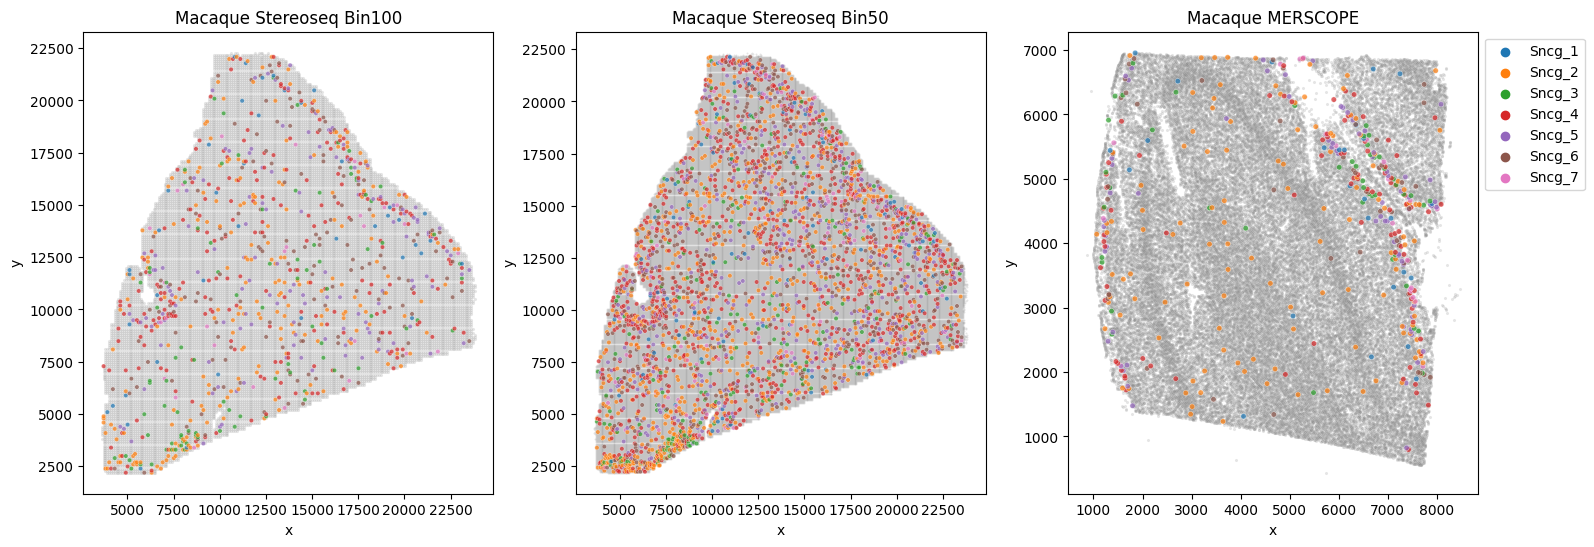

In [73]:
subclass = 'Sncg'

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=tg_stereoseq.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[0])
sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=10, legend=False,
                hue_order=[l for l in tg_stereoseq.ordered_labels['cluster'] if l.startswith(subclass)], ax=ax[0])
# sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['cluster']=='L2/3 IT_15'],
#                x='x', y='y', color='k', size=30, ax=ax[0])
ax[0].set_title('Macaque Stereoseq Bin100')
# ax[0].set_xlim(10000, 17500)
# ax[0].set_ylim(15000, 22000)

sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=2, ax=ax[1])
sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=10, legend=False,
                hue_order=[l for l in tg_stereoseq_bin50.ordered_labels['cluster'] if l.startswith(subclass)], ax=ax[1])
ax[1].set_title('Macaque Stereoseq Bin50')
# ax[1].set_xlim(10000, 17500)
# ax[1].set_ylim(15000, 22000)

sns.scatterplot(data=tg_map.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[2])
sns.scatterplot(data=tg_map.ad_sp.obsm['discrete_ct_pred'][tg_map.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=15, 
                hue_order=[l for l in tg_map.ordered_labels['cluster'] if l.startswith(subclass)], ax=ax[2])
ax[2].set_title('Macaque MERSCOPE')
ax[2].legend(bbox_to_anchor=(1,1))
# ax[1].set_xlim(5000, 8000)
# ax[1].set_ylim(2000, 5000)


(1500.0, 6000.0)

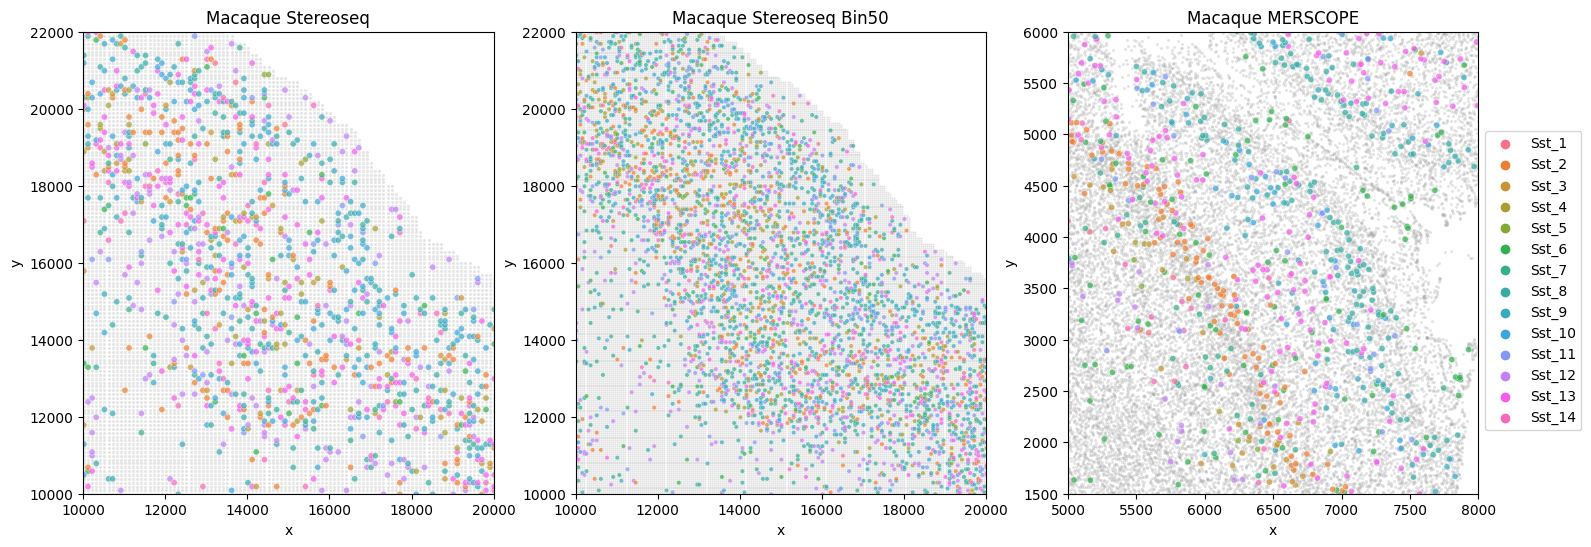

In [80]:
subclass = 'Sst'

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=tg_stereoseq.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[0])
sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=20, legend=False,
                hue_order=[l for l in tg_stereoseq.ordered_labels['cluster'] if l.startswith('Sst_')], ax=ax[0])
# sns.scatterplot(data=tg_stereoseq.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq.ad_sp.obsm['discrete_ct_pred']['cluster']=='L2/3 IT_15'],
#                x='x', y='y', color='k', size=30, ax=ax[0])
ax[0].set_title('Macaque Stereoseq')
ax[0].set_xlim(10000, 20000)
ax[0].set_ylim(10000, 22000)

sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=2, ax=ax[1])
sns.scatterplot(data=tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred'][tg_stereoseq_bin50.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=10, legend=False,
                hue_order=[l for l in tg_stereoseq_bin50.ordered_labels['cluster'] if l.startswith('Sst_')], ax=ax[1])
ax[1].set_title('Macaque Stereoseq Bin50')
ax[1].set_xlim(10000, 20000)
ax[1].set_ylim(10000, 22000)

sns.scatterplot(data=tg_map.ad_sp.obs, x='x', y='y', color='grey', alpha=0.2, s=5, ax=ax[2])
sns.scatterplot(data=tg_map.ad_sp.obsm['discrete_ct_pred'][tg_map.ad_sp.obsm['discrete_ct_pred']['subclass']==subclass], 
                x='x', y='y', hue='cluster', alpha=0.7, s=20, 
                hue_order=[l for l in tg_map.ordered_labels['cluster'] if l.startswith('Sst_')], ax=ax[2])
ax[2].set_title('Macaque MERSCOPE')
ax[2].legend(bbox_to_anchor=(1,0.8))
ax[2].set_xlim(5000, 8000)
ax[2].set_ylim(1500, 6000)


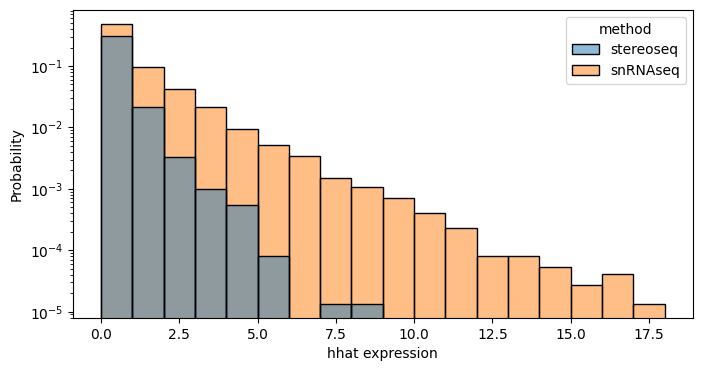

In [40]:
gene = 'hhat'
gene_dist_stereo = tg_stereoseq.ad_sp[:, [gene]].to_df().rename(columns={gene: 'stereoseq'})
gene_dist_sc = tg_stereoseq.ad_sc[:, [gene]].to_df().rename(columns={gene: 'snRNAseq'})
if gene in tg_map.ad_sp.uns['overlap_genes']:
    gene_dist_merscope = tg_map.ad_sp[:, gene].to_df().rename(columns={gene: 'MERSCOPE'})
else:
    gene_dist_merscope = None

gene_dist = pd.concat([gene_dist_stereo, gene_dist_sc, gene_dist_merscope], axis=1).melt()
gene_dist.rename(columns={'value': f'{gene} expression', 'variable': 'method'}, inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(gene_dist, x=f'{gene} expression', stat='probability', ax=ax, hue= 'method', binwidth=1)
ax.set_yscale('log')

In [37]:
tg_map.ad_sc

AnnData object with n_obs × n_vars = 49747 × 31200
    obs: 'cluster', 'subclass', 'class'
    var: 'n_cells'
    uns: 'training_genes', 'overlap_genes'